<a href="https://colab.research.google.com/github/konucha/waste-classification/blob/main/waste_classification_with_3_archi%2Bconfm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import module

In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

from numpy import random
from tensorflow import keras

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define path dataset

In [3]:
base_path = "/content/drive/MyDrive/Colab Notebooks/data-sampah/dataset/"
dataset_train = os.path.join(base_path, 'train')
dataset_test = os.path.join(base_path, 'test')
print(os.listdir(dataset_train))
print(os.listdir(dataset_test))

['plastic', 'glass', 'cardboard', 'paper', 'metal']
['paper', 'plastic', 'glass', 'cardboard', 'metal']


# Delete unnecessary hidden files

In [4]:
import glob
import shutil

def delete(path):
    if os.path.isfile(path) or os.path.islink(path):
        os.remove(path)
    elif os.path.isdir(path):
        shutil.rmtree(path)
    print('deleted: ' + path)

n = 0
for root, subdir, file in os.walk(dataset_train):
    pattern = os.path.join(root, '.*')
    for path in (glob.glob(pattern)):
        n += 1
        # print(path)
        delete(path)
print(f'{n} hidden file or folder found')

0 hidden file or folder found


# Check invalid image

In [5]:
from tensorflow.errors import InvalidArgumentError

def check_invalid_image(dataset_dir):
    invalid_images = list()
    for root, subdirs, files in os.walk(dataset_dir):
        for file in files:
            image_path = os.path.join(root, file)
            image = tf.io.read_file(image_path)
            try:    
                image = tf.io.decode_image(image,)
            except InvalidArgumentError:
                invalid_images.append(image_path)
    return (invalid_images, len(invalid_images))

data_train = check_invalid_image(dataset_train)
print(data_train)
data_test = check_invalid_image(dataset_test)
print(data_test)

# delete invalid image
for path_file in data_train[0]:
    os.remove(path_file)

for path_file in data_test[0]:
    os.remove(path_file)

([], 0)
([], 0)


# Check image detail

In [6]:
class_image = os.listdir(dataset_train)
class_image

['plastic', 'glass', 'cardboard', 'paper', 'metal']

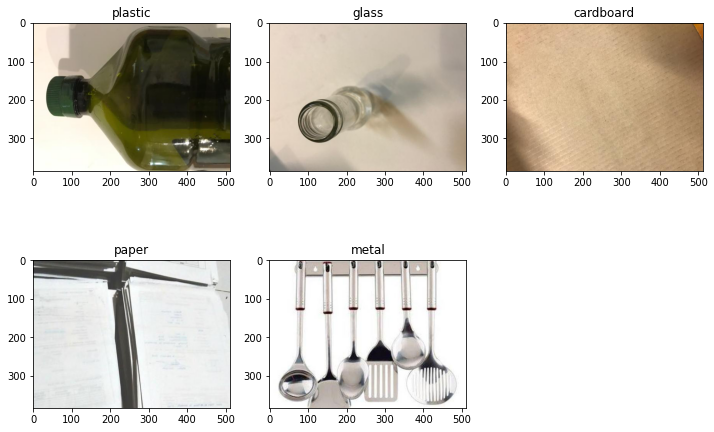

In [7]:
def get_random_data_perclass():
    random_data_perclass = []

    for root, _, files in os.walk(dataset_train):
        # skip check folder in data_resized
        if len(files) == 0: 
            continue
        random_index = random.randint(0, len(files) - 1)
        rand_data_path = os.path.join(root,  files[random_index])
        random_data_perclass.append(rand_data_path)
    return random_data_perclass

# subplot dimension
nrows = 2
ncols = 3

# Index for iterating over images
pic_index = 0
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

random_data = get_random_data_perclass()
for i, img_path in enumerate(random_data):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('On')
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(class_image[i])

In [8]:
def get_all_image_path():
    data = []
    for root, dirs, files in os.walk(dataset_train):
        # skip check folder in data_resized
        if len(files) == 0:
            continue
        for file in files:
            img_path = os.path.join(root, file)
            data.append(img_path)
    return data

# image description

In [9]:
# image description
n_data = len(get_all_image_path())
print("Number of image data: " + str(n_data))

image = mpimg.imread(random_data[random.randint(0, 5)])
print(f"Image height: {image.shape[0]}")
print(f"Image width: {image.shape[1]}")
print(f"Image channel: {image.ndim}")

Number of image data: 2500
Image height: 384
Image width: 512
Image channel: 3


# number of image per class in train dataset

In [10]:
for i, (_, __, files) in enumerate(os.walk(dataset_train)):
    if not files:
        continue
    print(f'{len(files)} images of {class_image[i - 1]}')

500 images of plastic
500 images of glass
500 images of cardboard
500 images of paper
500 images of metal


# Load image

# define hyperparameter

In [11]:
BATCH_SIZE = 120
IMG_HEIGHT = 256
IMG_WIDTH = 256

# load image as tf.dataset

In [12]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_train,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode = 'categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_train,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode = 'categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_test,
    label_mode = 'categorical',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 2500 files belonging to 5 classes.
Using 2000 files for training.
Found 2500 files belonging to 5 classes.
Using 500 files for validation.
Found 862 files belonging to 5 classes.


In [13]:
class_names = train_ds.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic']


# Show sample image from tf.dataset

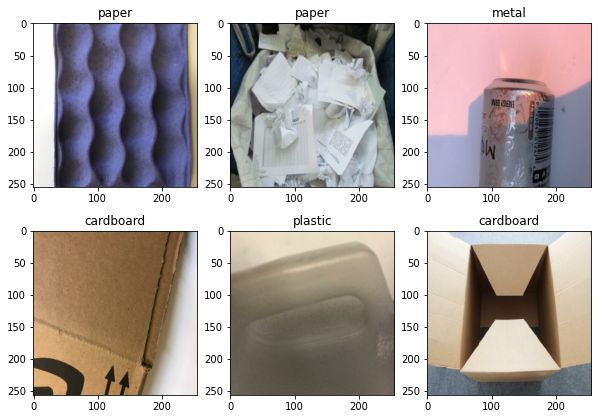

In [14]:
@tf.function
def ds(data):
    return next(iter(data))

image_batch, label_batch = ds(train_ds)
plt.figure(figsize=(10, 7))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    index_classnames = np.argmax(np.array(label))
    plt.title(class_names[index_classnames])
    plt.axis("on")

# Image Augmentaion

In [15]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_HEIGHT, IMG_WIDTH),
    tf.keras.layers.Rescaling(1./255.)
])

data_augmentation = tf.keras.Sequential([ 
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation((-0.3,0.3)),
    tf.keras.layers.RandomZoom((-0.2,0.1)),
    tf.keras.layers.RandomTranslation(0.1,0.1)
])

# Modeling

# Transfer learning Xception

In [16]:
xception_model = tf.keras.applications.xception.Xception(
    include_top=False, 
    weights='imagenet', 
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)
xception_model.trainable = False

83683744/83683744 [==============================] - 6s 0us/step


In [17]:
xception_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 127, 127, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [18]:
model_xception = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    resize_and_rescale,
    data_augmentation,
    xception_model,

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# model.build(input_shape=(256, 256, 3))

# Transfer learning ResNet50

In [19]:
resnet_model = tf.keras.applications.resnet50.ResNet50(
    include_top=False, 
    weights='imagenet', 
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)
resnet_model.trainable = False

94765736/94765736 [==============================] - 7s 0us/step


In [20]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [21]:
model_resnet = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    resize_and_rescale,
    data_augmentation,
    resnet_model,

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# model.build(input_shape=(256, 256, 3))

# Transfer learning VGG16

In [22]:
vgg_model = tf.keras.applications.vgg16.VGG16(
    include_top=False, 
    weights='imagenet', 
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)
vgg_model.trainable = False

58889256/58889256 [==============================] - 5s 0us/step


In [23]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [24]:
model_vgg = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    resize_and_rescale,
    data_augmentation,
    vgg_model,

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])

# model.build(input_shape=(256, 256, 3))

# Training Data

# Training Xception

In [25]:
model_xception.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 128)               16777344  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 5)                

In [26]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 35.7 MB/s 


In [27]:
import tensorflow_addons as tfa

In [28]:
model_xception.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=(0.001)),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=5,
                                                  average='macro',
                                                  threshold=0.5)])

In [29]:
ACCURACY_THRESHOLD = 0.95
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

In [30]:
callbacks = myCallback()
history_xception = model_xception.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/50


17/17 [==============================] - 60s 2s/step - loss: 3.5356 - accuracy: 0.5455 - precision: 0.5716 - recall: 0.5290 - f1_score: 0.5491 - val_loss: 0.9681 - val_accuracy: 0.7740 - val_precision: 0.7812 - val_recall: 0.7640 - val_f1_score: 0.7683
Epoch 2/50
17/17 [==============================] - 34s 2s/step - loss: 1.0649 - accuracy: 0.7515 - precision: 0.7620 - recall: 0.7460 - f1_score: 0.7544 - val_loss: 0.9488 - val_accuracy: 0.7820 - val_precision: 0.7838 - val_recall: 0.7760 - val_f1_score: 0.7734
Epoch 3/50
17/17 [==============================] - 35s 2s/step - loss: 0.7298 - accuracy: 0.8065 - precision: 0.8158 - recall: 0.7995 - f1_score: 0.8074 - val_loss: 0.7133 - val_accuracy: 0.7980 - val_precision: 0.8061 - val_recall: 0.7900 - val_f1_score: 0.7967
Epoch 4/50
17/17 [==============================] - 34s 2s/step - loss: 0.5689 - accuracy: 0.8250 - precision: 0.8343 - recall: 0.8180 - f1_score: 0.8263 - val_loss: 0.7935 - val_accuracy: 0.7800 - val_precision: 0.7864

# Training ResNet 50

In [31]:
model_resnet.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_3 (Dense)             (None, 128)               16777344  
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 5)                

In [32]:
model_resnet.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=(0.001)),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=5,
                                                  average='macro',
                                                  threshold=0.5)])

In [33]:
callbacks = myCallback()
history_resnet = model_resnet.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/50


17/17 [==============================] - 48s 2s/step - loss: 7.8794 - accuracy: 0.1985 - precision_1: 0.1985 - recall_1: 0.1965 - f1_score: 0.1933 - val_loss: 4.9318 - val_accuracy: 0.2120 - val_precision_1: 0.2124 - val_recall_1: 0.2120 - val_f1_score: 0.1011
Epoch 2/50
17/17 [==============================] - 31s 2s/step - loss: 3.4066 - accuracy: 0.2190 - precision_1: 0.2231 - recall_1: 0.2085 - f1_score: 0.2132 - val_loss: 3.9216 - val_accuracy: 0.2200 - val_precision_1: 0.2200 - val_recall_1: 0.2200 - val_f1_score: 0.1118
Epoch 3/50
17/17 [==============================] - 31s 2s/step - loss: 2.4360 - accuracy: 0.2515 - precision_1: 0.2542 - recall_1: 0.1820 - f1_score: 0.2067 - val_loss: 1.5770 - val_accuracy: 0.3240 - val_precision_1: 0.4151 - val_recall_1: 0.0440 - val_f1_score: 0.0685
Epoch 4/50
17/17 [==============================] - 31s 2s/step - loss: 1.8417 - accuracy: 0.2700 - precision_1: 0.2981 - recall_1: 0.1015 - f1_score: 0.1491 - val_loss: 1.9290 - val_accuracy: 0.

# Training VGG 16

In [34]:
model_vgg.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               4194432   
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 5)                

In [35]:
model_vgg.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=(0.001)),
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=5,
                                                  average='macro',
                                                  threshold=0.5)])

In [36]:
callbacks = myCallback()
history_vgg = model_vgg.fit(train_ds,
                    validation_data=val_ds,
                    epochs=50,
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/50


17/17 [==============================] - 63s 3s/step - loss: 1.7835 - accuracy: 0.3270 - precision_2: 0.3666 - recall_2: 0.2330 - f1_score: 0.2858 - val_loss: 1.1742 - val_accuracy: 0.5000 - val_precision_2: 0.5936 - val_recall_2: 0.2980 - val_f1_score: 0.3672
Epoch 2/50
17/17 [==============================] - 37s 2s/step - loss: 1.1087 - accuracy: 0.5580 - precision_2: 0.7028 - recall_2: 0.3310 - f1_score: 0.4336 - val_loss: 1.0101 - val_accuracy: 0.5940 - val_precision_2: 0.7224 - val_recall_2: 0.3540 - val_f1_score: 0.4480
Epoch 3/50
17/17 [==============================] - 36s 2s/step - loss: 0.9692 - accuracy: 0.6125 - precision_2: 0.7351 - recall_2: 0.4370 - f1_score: 0.5401 - val_loss: 0.9255 - val_accuracy: 0.6020 - val_precision_2: 0.7209 - val_recall_2: 0.4700 - val_f1_score: 0.5299
Epoch 4/50
17/17 [==============================] - 37s 2s/step - loss: 0.9537 - accuracy: 0.6290 - precision_2: 0.7201 - recall_2: 0.4720 - f1_score: 0.5578 - val_loss: 0.8658 - val_accuracy: 0.

# Plotting result training

# Plot Xception

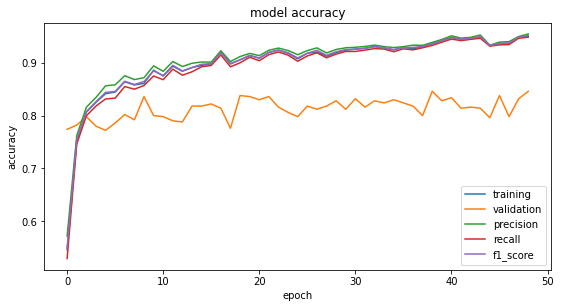

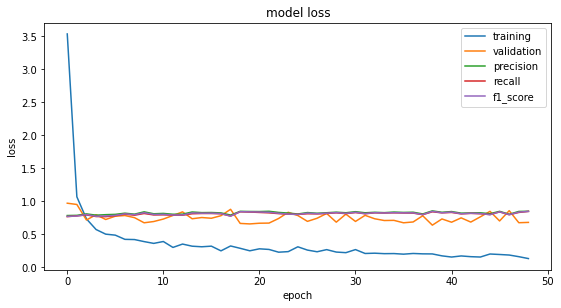

In [37]:
from matplotlib.pyplot import figure
figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.plot(history_xception.history['accuracy'])
plt.plot(history_xception.history['val_accuracy'])
plt.plot(history_xception.history['precision'])
plt.plot(history_xception.history['recall'])
plt.plot(history_xception.history['f1_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation', 'precision', 'recall', 'f1_score'], loc='lower right')

figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(history_xception.history['loss'])
plt.plot(history_xception.history['val_loss'])
plt.plot(history_xception.history['val_precision'])
plt.plot(history_xception.history['val_recall'])
plt.plot(history_xception.history['val_f1_score'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation', 'precision', 'recall', 'f1_score'], loc='upper right')
plt.show()

# Plot ResNet 50

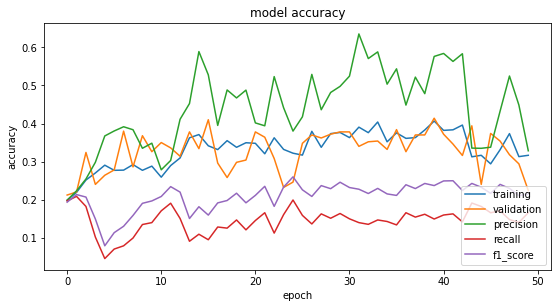

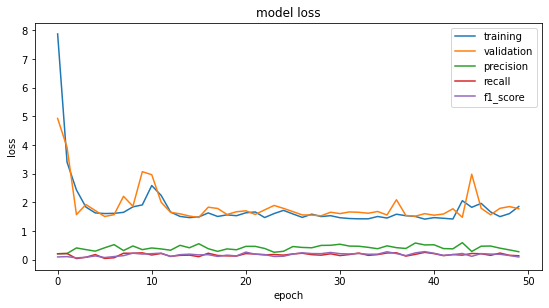

In [38]:
from matplotlib.pyplot import figure
figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])
plt.plot(history_resnet.history['precision_1'])
plt.plot(history_resnet.history['recall_1'])
plt.plot(history_resnet.history['f1_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation', 'precision', 'recall', 'f1_score'], loc='lower right')

figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.plot(history_resnet.history['val_precision_1'])
plt.plot(history_resnet.history['val_recall_1'])
plt.plot(history_resnet.history['val_f1_score'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation', 'precision', 'recall', 'f1_score'], loc='upper right')
plt.show()

# Plot VGG 16

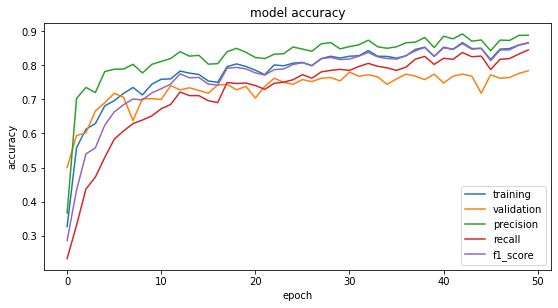

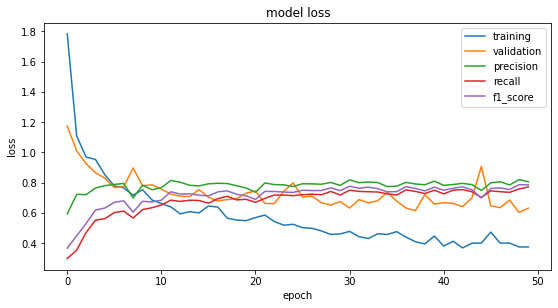

In [39]:
from matplotlib.pyplot import figure
figure(figsize=(20, 10))

plt.subplot(2, 2, 1)
plt.plot(history_vgg.history['accuracy'])
plt.plot(history_vgg.history['val_accuracy'])
plt.plot(history_vgg.history['precision_2'])
plt.plot(history_vgg.history['recall_2'])
plt.plot(history_vgg.history['f1_score'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation', 'precision', 'recall', 'f1_score'], loc='lower right')

figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(history_vgg.history['loss'])
plt.plot(history_vgg.history['val_loss'])
plt.plot(history_vgg.history['val_precision_2'])
plt.plot(history_vgg.history['val_recall_2'])
plt.plot(history_vgg.history['val_f1_score'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation', 'precision', 'recall', 'f1_score'], loc='upper right')
plt.show()

# Evaluate model

# Evaluate Model Xception



In [40]:
model_xception.evaluate(test_ds)

8/8 [==============================] - 8s 734ms/step - loss: 0.5474 - accuracy: 0.8457 - precision: 0.8528 - recall: 0.8399 - f1_score: 0.8455


[0.5474012494087219,
 0.8457076549530029,
 0.8527679443359375,
 0.839907169342041,
 0.8454569578170776]

# Evaluate Model ResNet 50

In [41]:
model_resnet.evaluate(test_ds)

8/8 [==============================] - 6s 518ms/step - loss: 1.6332 - accuracy: 0.3005 - precision_1: 0.3937 - recall_1: 0.2042 - f1_score: 0.1373


[1.6332005262374878,
 0.30046403408050537,
 0.39373600482940674,
 0.20417633652687073,
 0.1372503936290741]

# Evaluate Model VGG 16

In [42]:
model_vgg.evaluate(test_ds)

8/8 [==============================] - 10s 1s/step - loss: 0.7027 - accuracy: 0.7599 - precision_2: 0.7778 - recall_2: 0.7390 - f1_score: 0.7565


[0.702673614025116,
 0.7598608136177063,
 0.7777777910232544,
 0.7389791011810303,
 0.7564598321914673]

# Save Model

In [43]:
# import datetime
# now = datetime.datetime.now()
# time = now.strftime("%Y-%m-%d_%H:%M:%S")
# path_h5 = os.path.join('/content/drive/MyDrive/Bangkit/Capstone/', 'modelh5')

In [44]:
# model.save( os.path.join(path_h5, f'trashnet_{time}-xception-(256x256)-augmented-preprocessing-plus-newdataset-fix-shape.h5'))

# Try prediction with new data

Saving IMG-20191117-WA0037.jpg to IMG-20191117-WA0037.jpg
1/1 [==============================] - 1s 1s/step


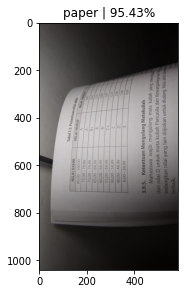

In [45]:
class_names = train_ds.class_names

import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
i = 0
plt.figure(figsize=(15, 10))
for fn in uploaded.keys():
    img_path = os.path.join('/content', fn)
    img = tf.keras.utils.load_img(
        img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    
    img_array = tf.keras.utils.img_to_array(img)    
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model_xception.predict(img_array)

    sp = plt.subplot(2, 3, i + 1)
    img = mpimg.imread(img_path) 
    plt.imshow(img)
    plt.title(f"{class_names[np.argmax(predictions[0])]} | {100 * np.max(predictions[0]):.2f}%")
    # print(f"{class_names[np.argmax(predictions[0])]} with a {100 * np.max(predictions[0]):.2f} percent confidence.")

Saving IMG-20191117-WA0037.jpg to IMG-20191117-WA0037 (1).jpg
1/1 [==============================] - 1s 1s/step


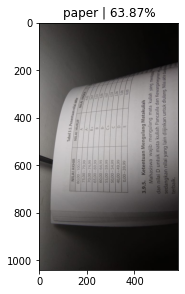

In [46]:
class_names = train_ds.class_names

import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
i = 0
plt.figure(figsize=(15, 10))
for fn in uploaded.keys():
    img_path = os.path.join('/content', fn)
    img = tf.keras.utils.load_img(
        img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    
    img_array = tf.keras.utils.img_to_array(img)    
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model_resnet.predict(img_array)

    sp = plt.subplot(2, 3, i + 1)
    img = mpimg.imread(img_path) 
    plt.imshow(img)
    plt.title(f"{class_names[np.argmax(predictions[0])]} | {100 * np.max(predictions[0]):.2f}%")
    # print(f"{class_names[np.argmax(predictions[0])]} with a {100 * np.max(predictions[0]):.2f} percent confidence.")

Saving IMG-20191117-WA0037.jpg to IMG-20191117-WA0037 (2).jpg
1/1 [==============================] - 1s 642ms/step


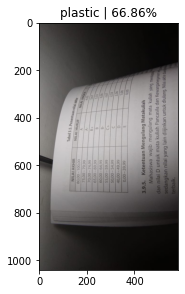

In [47]:
class_names = train_ds.class_names

import numpy as np

from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()
i = 0
plt.figure(figsize=(15, 10))
for fn in uploaded.keys():
    img_path = os.path.join('/content', fn)
    img = tf.keras.utils.load_img(
        img_path, target_size=(IMG_HEIGHT, IMG_WIDTH)
    )
    
    img_array = tf.keras.utils.img_to_array(img)    
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model_vgg.predict(img_array)

    sp = plt.subplot(2, 3, i + 1)
    img = mpimg.imread(img_path) 
    plt.imshow(img)
    plt.title(f"{class_names[np.argmax(predictions[0])]} | {100 * np.max(predictions[0]):.2f}%")
    # print(f"{class_names[np.argmax(predictions[0])]} with a {100 * np.max(predictions[0]):.2f} percent confidence.")

# Confusion Matrix

In [89]:
# from sklearn.metrics import plot_confusion_matrix
# plot_confusion_matrix(model_xception, val_ds, class_names)

In [90]:
# class estimator:
#   _estimator_type = ''
#   classes_=[]
#   def __init__(self, model, classes):
#     self.model = model
#     self._estimator_type = 'classifier'
#     self.classes_ = classes
#   def predict(self, X):
#     y_prob= self.model.predict(X)
#     y_pred = y_prob.argmax(axis=1)
#     return y_pred

# classifier = estimator(model_xception, class_image)

In [91]:
# plot_confusion_matrix(estimator=classifier, X=train_ds, y_true=class_image)

In [92]:
# class_names = train_ds.class_names

# train_labels = np.concatenate([y for x, y in train_ds], axis=0)
# train_labels1 = np.concatenate([y for x, y in train_ds], axis=0)  # repull traiing labels

# validation_labels = np.concatenate([y for x, y in val_ds], axis=0)
# validation_labels1 = tf.concat([y for x, y in val_ds], axis=0).numpy()  # repull validation labels


In [93]:
# prediction = model_xception.predict(val_ds)
# score = model_xception.evaluate(val_ds, verbose=0)
# validation_pred = np.argmax(prediction, axis = 1)
# cm = confusion_matrix(validation_labels, validation_pred)

In [94]:
# y_hat = model_xception.predict(test_ds)
# y_test = np.concatenate([y for x, y in test_ds], axis=0)
# c_matrix = confusion_matrix(np.argmax(y_test, axis=-1),
#                             np.argmax(y_hat, axis=-1))

In [95]:
# print(c_matrix)

In [96]:
# y_hat = model_xception.predict(test_ds)
# y_test = np.concatenate([y for x, y in test_ds], axis=0)
# true_class = tf.argmax(y_test, 1)
# predicted_class = tf.argmax(y_hat, 1)
# cm = tf.math.confusion_matrix(true_class, predicted_class,)
# print(cm)

In [97]:
# predictions = model_xception.predict_classes(test_ds)

# y_pred = []
# y_true = []

# # iterate over the dataset
# for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
#    # append true labels
#    y_true.append(label_batch)
#    # compute predictions
#    preds = model_xception.predict(image_batch)
#    # append predicted labels
#    y_pred.append(np.argmax(preds, axis = - 1))

# # convert the true and predicted labels into tensors
# true_labels = tf.concat([item for item in y_true], axis = 0)
# predicted_labels = tf.concat([item for item in y_pred], axis = 0)


# from sklearn.metrics import confusion_matrix

# cm = confusion_matrix(true_labels, predicted_labels)
# print(cm)

## Xception

In [141]:
predicted_classes = np.array([])
true_classes =  np.array([])

for x, y in test_ds:
  predicted_classes = np.concatenate([predicted_classes,
                       np.argmax(model_xception(x), axis = -1)])
  true_classes = np.concatenate([true_classes, np.argmax(y.numpy(), axis=-1)])

In [142]:
cm_xception = tf.math.confusion_matrix(true_classes, predicted_classes, )
print(cm_xception)

tf.Tensor(
[[ 90   0   2   7   3]
 [  1 156  19   0  31]
 [  2   6 147   3  14]
 [ 16   0   6 192   7]
 [  0   9   6   1 144]], shape=(5, 5), dtype=int32)


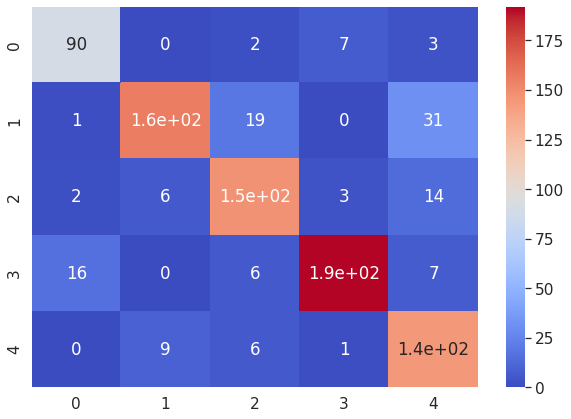

In [143]:
import seaborn as sns

plt.figure(figsize = (10,7))
sns.heatmap(cm_xception, annot=True, cmap='coolwarm')

## ResNet50

In [144]:
predicted_classes = np.array([])
true_classes =  np.array([])

for x, y in test_ds:
  predicted_classes = np.concatenate([predicted_classes,
                       np.argmax(model_resnet(x), axis = -1)])
  true_classes = np.concatenate([true_classes, np.argmax(y.numpy(), axis=-1)])

In [145]:
cm_resnet = tf.math.confusion_matrix(true_classes, predicted_classes,)
print(cm_resnet)

tf.Tensor(
[[  4   0   1  97   0]
 [  1  12  10 184   0]
 [  5   7  28 132   0]
 [  1   2   3 215   0]
 [  0   8   3 149   0]], shape=(5, 5), dtype=int32)


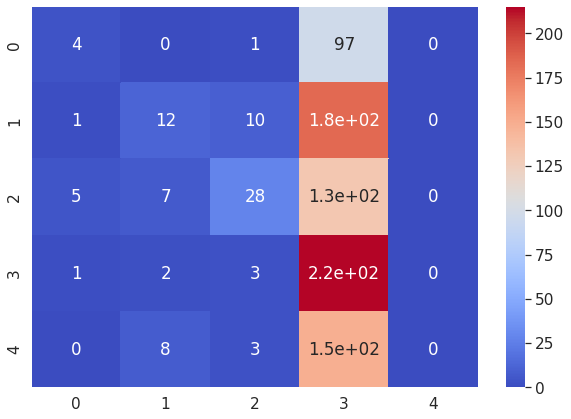

In [146]:
import seaborn as sns

plt.figure(figsize = (10,7))
sns.heatmap(cm_resnet, annot=True, cmap='coolwarm')

## VGG16

In [147]:
predicted_classes = np.array([])
true_classes =  np.array([])

for x, y in test_ds:
  predicted_classes = np.concatenate([predicted_classes,
                       np.argmax(model_vgg(x), axis = -1)])
  true_classes = np.concatenate([true_classes, np.argmax(y.numpy(), axis=-1)])

In [148]:
cm_vgg = tf.math.confusion_matrix(true_classes, predicted_classes,)
print(cm_vgg)

tf.Tensor(
[[ 89   1   2   9   1]
 [  3 138  30   2  34]
 [  5  23 129   3  12]
 [ 28   3   4 181   5]
 [  3  15  15   9 118]], shape=(5, 5), dtype=int32)


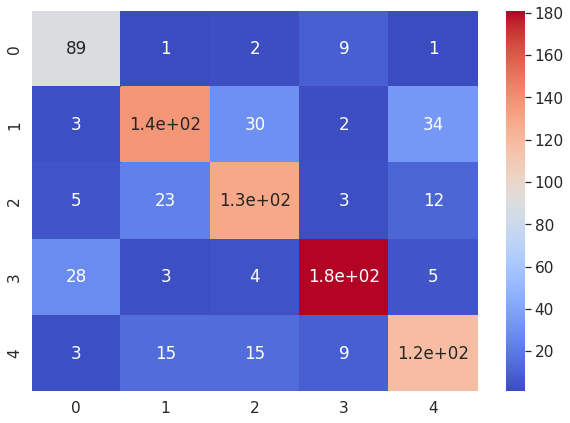

In [149]:
import seaborn as sns

plt.figure(figsize = (10,7))
sns.heatmap(cm_vgg, annot=True, cmap='coolwarm')